## Download Dataset

In [1]:
!kaggle competitions download -c caterpillar-tube-pricing
!unzip data.zip

100%|████████████████████████████████████████| 225k/225k [00:00<00:00, 2.06MB/s]

  0%|                                                | 0.00/794k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 794k/794k [00:00<00:00, 9.57MB/s]
Archive:  data.zip
   creating: competition_data/
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  

## Load Dataframes

In [2]:
from glob import glob
import pandas as pd
data = {}
for path in glob('competition_data/*.csv'):
    name = path.split('/')[-1].split('.')[0]
    data[name] = pd.read_csv(path)
    print(path, data[name].shape)

competition_data/tube_end_form.csv (27, 2)
competition_data/components.csv (2048, 3)
competition_data/type_end_form.csv (8, 2)
competition_data/comp_threaded.csv (194, 32)
competition_data/type_connection.csv (14, 2)
competition_data/comp_hfl.csv (6, 9)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/comp_float.csv (16, 7)
competition_data/type_component.csv (29, 2)
competition_data/comp_straight.csv (361, 12)
competition_data/test_set.csv (30235, 8)
competition_data/comp_other.csv (1001, 3)
competition_data/comp_sleeve.csv (50, 10)
competition_data/tube.csv (21198, 16)
competition_data/comp_tee.csv (4, 14)
competition_data/comp_nut.csv (65, 11)
competition_data/comp_boss.csv (147, 15)
competition_data/specs.csv (21198, 11)
competition_data/train_set.csv (30213, 8)
competition_data/comp_adaptor.csv (25, 20)
competition_data/comp_elbow.csv (178, 16)


## Train/Val Split

In [3]:
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

trainval = data['train_set']
test = data['test_set']
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

## Data Wrangling and Feature Engineering

In [6]:
import pandas as pd
materials = data['bill_of_materials']

assembly_components = materials.melt(id_vars='tube_assembly_id', 
                                     value_vars=[f'component_id_{n}' for n in range(1,9)])

assembly_components = (assembly_components
                       .sort_values(by='tube_assembly_id')
                       .dropna()
                       .rename(columns={'value': 'component_id'}))

assembly_components.head(10)

,tube_assembly_id,variable,component_id
0,TA-00001,component_id_1,C-1622
21198,TA-00001,component_id_2,C-1629
1,TA-00002,component_id_1,C-1312
2,TA-00003,component_id_1,C-1312
3,TA-00004,component_id_1,C-1312
4,TA-00005,component_id_1,C-1624
42400,TA-00005,component_id_3,C-1641
21202,TA-00005,component_id_2,C-1631
5,TA-00006,component_id_1,C-1624
21203,TA-00006,component_id_2,C-1631


In [7]:
components = pd.read_csv('competition_data/components.csv')
assembly_component_types = assembly_components.merge(components, how='left')
assembly_component_types.head(10)

,tube_assembly_id,variable,component_id,name,component_type_id
0,TA-00001,component_id_1,C-1622,NUT-SWIVEL,CP-025
1,TA-00001,component_id_2,C-1629,SLEEVE-ORFS,CP-024
2,TA-00002,component_id_1,C-1312,NUT-FLARED,CP-028
3,TA-00003,component_id_1,C-1312,NUT-FLARED,CP-028
4,TA-00004,component_id_1,C-1312,NUT-FLARED,CP-028
5,TA-00005,component_id_1,C-1624,NUT-SWIVEL,CP-025
6,TA-00005,component_id_3,C-1641,CONNECTOR-SEAL,CP-014
7,TA-00005,component_id_2,C-1631,SLEEVE-ORFS,CP-024
8,TA-00006,component_id_1,C-1624,NUT-SWIVEL,CP-025
9,TA-00006,component_id_2,C-1631,SLEEVE-ORFS,CP-024


In [8]:
table = pd.crosstab(assembly_component_types['tube_assembly_id'], 
                    assembly_component_types['component_type_id'])

table = table.reset_index()
table.columns.name = ''
print(table.shape)
table.head()

(19149, 30)


,tube_assembly_id,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,CP-008,CP-009,...,CP-021,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER
0,TA-00001,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,TA-00002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,TA-00003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,TA-00004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,TA-00005,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [10]:
def search_column(name):
    for key in data.keys():
        df = data[key]
        if name in df.columns:
            print(path, df.shape)
            print(df.columns.tolist(), '\n')

search_column('weight')

competition_data/comp_elbow.csv (194, 32)
['component_id', 'component_type_id', 'adaptor_angle', 'overall_length', 'hex_size', 'end_form_id_1', 'connection_type_id_1', 'length_1', 'thread_size_1', 'thread_pitch_1', 'nominal_size_1', 'end_form_id_2', 'connection_type_id_2', 'length_2', 'thread_size_2', 'thread_pitch_2', 'nominal_size_2', 'end_form_id_3', 'connection_type_id_3', 'length_3', 'thread_size_3', 'thread_pitch_3', 'nominal_size_3', 'end_form_id_4', 'connection_type_id_4', 'length_4', 'thread_size_4', 'thread_pitch_4', 'nominal_size_4', 'unique_feature', 'orientation', 'weight'] 

competition_data/comp_elbow.csv (6, 9)
['component_id', 'component_type_id', 'hose_diameter', 'corresponding_shell', 'coupling_class', 'material', 'plating', 'orientation', 'weight'] 

competition_data/comp_elbow.csv (16, 7)
['component_id', 'component_type_id', 'bolt_pattern_long', 'bolt_pattern_wide', 'thickness', 'orientation', 'weight'] 

competition_data/comp_elbow.csv (361, 12)
['component_id', 

In [11]:
comp_threaded = data['comp_threaded']
comp_threaded['orientation'].value_counts()

No     121
Yes     73
Name: orientation, dtype: int64

In [12]:
comp_threaded['unique_feature'].value_counts()

No     161
Yes     33
Name: unique_feature, dtype: int64

In [14]:
comp = pd.concat((pd.read_csv(path) for path in glob('competition_data/comp_*.csv')), sort=False)
columns = ['component_id', 'component_type_id', 'orientation', 'unique_feature', 'weight']
comp = comp[columns]
comp['orientation'] = (comp['orientation']=='Yes').astype(int)
comp['unique_feature'] = (comp['unique_feature']=='Yes').astype(int)
comp['weight'] = comp['weight'].fillna(comp['weight'].median())
comp.head()

,component_id,component_type_id,orientation,unique_feature,weight
0,C-0007,CP-014,0,0,0.028
1,C-0030,CP-015,1,0,0.914
2,C-0041,CP-014,0,0,0.120
3,C-0043,CP-014,0,0,0.090
4,C-0044,CP-014,0,0,0.182


In [15]:
materials['components_total'] = sum(materials[f'quantity_{n}'].fillna(0)  for n in range(1,9))
materials['components_distinct'] = sum(materials[f'component_id_{n}'].notnull().astype(int) for n in range(1,9))
materials['orientation'] = 0
materials['unique_feature'] = 0
materials['weight'] = 0

for n in range(1,9):
    materials = materials.merge(comp, left_on=f'component_id_{n}', right_on='component_id', 
                                how='left', suffixes=('', f'_{n}'))

for col in materials:
    if 'orientation' in col or 'unique_feature' in col or 'weight' in col:
        materials[col] = materials[col].fillna(0)
        
materials['orientation'] = sum(materials[f'orientation_{n}'] for n in range(1,9))
materials['unique_feature'] = sum(materials[f'unique_feature_{n}'] for n in range(1,9))
materials['weight'] = sum(materials[f'weight_{n}'] for n in range(1,9))

materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,...,component_id_7,component_type_id_7,orientation_7,unique_feature_7,weight_7,component_id_8,component_type_id_8,orientation_8,unique_feature_8,weight_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [16]:
features = ['tube_assembly_id', 'orientation', 'unique_feature', 'weight', 
            'components_total', 'components_distinct', 'component_id_1']
materials = materials[features]
print(materials.shape)
materials.head()

(21198, 7)


,tube_assembly_id,orientation,unique_feature,weight,components_total,components_distinct,component_id_1
0,TA-00001,0.0,1.0,0.048,4.0,2,C-1622
1,TA-00002,0.0,0.0,0.009,2.0,1,C-1312
2,TA-00003,0.0,0.0,0.009,2.0,1,C-1312
3,TA-00004,0.0,0.0,0.009,2.0,1,C-1312
4,TA-00005,0.0,1.0,0.210,3.0,3,C-1624


In [17]:
#Read tube data
tube = pd.read_csv('competition_data/tube.csv')
tube.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127.0,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [18]:
# Merge with train, test, val
from sklearn.model_selection import train_test_split

# Read data
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge data
    X = (X.merge(table, how='left')
         .merge(materials, how='left')
         .merge(tube, how='left')
         .fillna(0))
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [19]:
#log trasnform 
import numpy as np

target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

## Fit Model

In [23]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]
model = XGBRegressor(n_estimators=2000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[0]	validation_0-rmse:1.71966	validation_1-rmse:1.70913
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.56462	validation_1-rmse:1.55419
[2]	validation_0-rmse:1.42742	validation_1-rmse:1.41758
[3]	validation_0-rmse:1.30251	validation_1-rmse:1.29309
[4]	validation_0-rmse:1.19029	validation_1-rmse:1.18093
[5]	validation_0-rmse:1.09307	validation_1-rmse:1.08376
[6]	validation_0-rmse:1.00384	validation_1-rmse:0.994622
[7]	validation_0-rmse:0.925173	validation_1-rmse:0.916505
[8]	validation_0-rmse:0.856916	validation_1-rmse:0.849009
[9]	validation_0-rmse:0.794484	validation_1-rmse:0.786692
[10]	validation_0-rmse:0.741354	validation_1-rmse:0.734697
[11]	validation_0-rmse:0.693082	validation_1-rmse:0.686451
[12]	validation_0-rmse:0.652638	validation_1-rmse:0.647214
[13]	validation_0-rmse:0.61466	validation_1-rmse:0.60953
[14]	validation_0-rmse:0.582012	validati

[137]	validation_0-rmse:0.285487	validation_1-rmse:0.302551
[138]	validation_0-rmse:0.285185	validation_1-rmse:0.302387
[139]	validation_0-rmse:0.284828	validation_1-rmse:0.301915
[140]	validation_0-rmse:0.284015	validation_1-rmse:0.301574
[141]	validation_0-rmse:0.283672	validation_1-rmse:0.301276
[142]	validation_0-rmse:0.283569	validation_1-rmse:0.301196
[143]	validation_0-rmse:0.283349	validation_1-rmse:0.301057
[144]	validation_0-rmse:0.283258	validation_1-rmse:0.301
[145]	validation_0-rmse:0.283034	validation_1-rmse:0.30022
[146]	validation_0-rmse:0.282809	validation_1-rmse:0.300055
[147]	validation_0-rmse:0.282536	validation_1-rmse:0.300008
[148]	validation_0-rmse:0.281778	validation_1-rmse:0.299181
[149]	validation_0-rmse:0.281354	validation_1-rmse:0.298815
[150]	validation_0-rmse:0.281106	validation_1-rmse:0.29875
[151]	validation_0-rmse:0.28076	validation_1-rmse:0.298566
[152]	validation_0-rmse:0.280358	validation_1-rmse:0.298458
[153]	validation_0-rmse:0.279439	validation_1-

[275]	validation_0-rmse:0.253518	validation_1-rmse:0.282295
[276]	validation_0-rmse:0.253433	validation_1-rmse:0.282286
[277]	validation_0-rmse:0.25317	validation_1-rmse:0.282151
[278]	validation_0-rmse:0.252968	validation_1-rmse:0.282153
[279]	validation_0-rmse:0.252672	validation_1-rmse:0.282021
[280]	validation_0-rmse:0.252472	validation_1-rmse:0.281875
[281]	validation_0-rmse:0.252151	validation_1-rmse:0.281775
[282]	validation_0-rmse:0.251924	validation_1-rmse:0.281543
[283]	validation_0-rmse:0.251607	validation_1-rmse:0.281163
[284]	validation_0-rmse:0.251456	validation_1-rmse:0.281045
[285]	validation_0-rmse:0.251279	validation_1-rmse:0.281135
[286]	validation_0-rmse:0.251128	validation_1-rmse:0.281
[287]	validation_0-rmse:0.250911	validation_1-rmse:0.280976
[288]	validation_0-rmse:0.25086	validation_1-rmse:0.280988
[289]	validation_0-rmse:0.250696	validation_1-rmse:0.280897
[290]	validation_0-rmse:0.250531	validation_1-rmse:0.280905
[291]	validation_0-rmse:0.250174	validation_1

[413]	validation_0-rmse:0.233672	validation_1-rmse:0.272543
[414]	validation_0-rmse:0.233583	validation_1-rmse:0.272605
[415]	validation_0-rmse:0.233401	validation_1-rmse:0.272528
[416]	validation_0-rmse:0.233289	validation_1-rmse:0.272486
[417]	validation_0-rmse:0.233274	validation_1-rmse:0.272472
[418]	validation_0-rmse:0.233134	validation_1-rmse:0.272367
[419]	validation_0-rmse:0.233034	validation_1-rmse:0.27234
[420]	validation_0-rmse:0.233006	validation_1-rmse:0.272322
[421]	validation_0-rmse:0.232899	validation_1-rmse:0.272341
[422]	validation_0-rmse:0.232873	validation_1-rmse:0.272349
[423]	validation_0-rmse:0.232821	validation_1-rmse:0.27229
[424]	validation_0-rmse:0.23264	validation_1-rmse:0.272051
[425]	validation_0-rmse:0.232628	validation_1-rmse:0.272042
[426]	validation_0-rmse:0.232527	validation_1-rmse:0.272007
[427]	validation_0-rmse:0.232461	validation_1-rmse:0.271959
[428]	validation_0-rmse:0.232316	validation_1-rmse:0.271859
[429]	validation_0-rmse:0.232235	validation

[550]	validation_0-rmse:0.218928	validation_1-rmse:0.266158
[551]	validation_0-rmse:0.218814	validation_1-rmse:0.266135
[552]	validation_0-rmse:0.218587	validation_1-rmse:0.265943
[553]	validation_0-rmse:0.218566	validation_1-rmse:0.265914
[554]	validation_0-rmse:0.218505	validation_1-rmse:0.265929
[555]	validation_0-rmse:0.21836	validation_1-rmse:0.265781
[556]	validation_0-rmse:0.218282	validation_1-rmse:0.265728
[557]	validation_0-rmse:0.218237	validation_1-rmse:0.265761
[558]	validation_0-rmse:0.218176	validation_1-rmse:0.265735
[559]	validation_0-rmse:0.218111	validation_1-rmse:0.265718
[560]	validation_0-rmse:0.218056	validation_1-rmse:0.265703
[561]	validation_0-rmse:0.217974	validation_1-rmse:0.265652
[562]	validation_0-rmse:0.217927	validation_1-rmse:0.265616
[563]	validation_0-rmse:0.217842	validation_1-rmse:0.265646
[564]	validation_0-rmse:0.217824	validation_1-rmse:0.26565
[565]	validation_0-rmse:0.217794	validation_1-rmse:0.265623
[566]	validation_0-rmse:0.217642	validatio

[687]	validation_0-rmse:0.208444	validation_1-rmse:0.261956
[688]	validation_0-rmse:0.208329	validation_1-rmse:0.261858
[689]	validation_0-rmse:0.208318	validation_1-rmse:0.261855
[690]	validation_0-rmse:0.208245	validation_1-rmse:0.261852
[691]	validation_0-rmse:0.208188	validation_1-rmse:0.261822
[692]	validation_0-rmse:0.208045	validation_1-rmse:0.261745
[693]	validation_0-rmse:0.207985	validation_1-rmse:0.261643
[694]	validation_0-rmse:0.207845	validation_1-rmse:0.261486
[695]	validation_0-rmse:0.207775	validation_1-rmse:0.261515
[696]	validation_0-rmse:0.207718	validation_1-rmse:0.261504
[697]	validation_0-rmse:0.207663	validation_1-rmse:0.261467
[698]	validation_0-rmse:0.207576	validation_1-rmse:0.261365
[699]	validation_0-rmse:0.207468	validation_1-rmse:0.26132
[700]	validation_0-rmse:0.207423	validation_1-rmse:0.261229
[701]	validation_0-rmse:0.20732	validation_1-rmse:0.261082
[702]	validation_0-rmse:0.207247	validation_1-rmse:0.261095
[703]	validation_0-rmse:0.207175	validatio

[825]	validation_0-rmse:0.200469	validation_1-rmse:0.259149
[826]	validation_0-rmse:0.200405	validation_1-rmse:0.259158
[827]	validation_0-rmse:0.200381	validation_1-rmse:0.259087
[828]	validation_0-rmse:0.200365	validation_1-rmse:0.259046
[829]	validation_0-rmse:0.200327	validation_1-rmse:0.25902
[830]	validation_0-rmse:0.200248	validation_1-rmse:0.258981
[831]	validation_0-rmse:0.200169	validation_1-rmse:0.258974
[832]	validation_0-rmse:0.200082	validation_1-rmse:0.258993
[833]	validation_0-rmse:0.200067	validation_1-rmse:0.258952
[834]	validation_0-rmse:0.200024	validation_1-rmse:0.258949
[835]	validation_0-rmse:0.199908	validation_1-rmse:0.258863
[836]	validation_0-rmse:0.199901	validation_1-rmse:0.258849
[837]	validation_0-rmse:0.199852	validation_1-rmse:0.258853
[838]	validation_0-rmse:0.199738	validation_1-rmse:0.258749
[839]	validation_0-rmse:0.199657	validation_1-rmse:0.258654
[840]	validation_0-rmse:0.199554	validation_1-rmse:0.258573
[841]	validation_0-rmse:0.199529	validati

[962]	validation_0-rmse:0.192819	validation_1-rmse:0.255818
[963]	validation_0-rmse:0.192815	validation_1-rmse:0.255815
[964]	validation_0-rmse:0.192802	validation_1-rmse:0.255833
[965]	validation_0-rmse:0.192741	validation_1-rmse:0.255827
[966]	validation_0-rmse:0.192732	validation_1-rmse:0.255789
[967]	validation_0-rmse:0.192716	validation_1-rmse:0.255784
[968]	validation_0-rmse:0.192672	validation_1-rmse:0.255781
[969]	validation_0-rmse:0.19263	validation_1-rmse:0.255845
[970]	validation_0-rmse:0.192567	validation_1-rmse:0.255823
[971]	validation_0-rmse:0.192519	validation_1-rmse:0.255803
[972]	validation_0-rmse:0.192415	validation_1-rmse:0.255765
[973]	validation_0-rmse:0.192383	validation_1-rmse:0.255717
[974]	validation_0-rmse:0.192343	validation_1-rmse:0.255827
[975]	validation_0-rmse:0.192319	validation_1-rmse:0.255824
[976]	validation_0-rmse:0.192261	validation_1-rmse:0.255803
[977]	validation_0-rmse:0.192252	validation_1-rmse:0.255797
[978]	validation_0-rmse:0.192213	validati

[1098]	validation_0-rmse:0.186257	validation_1-rmse:0.254635
[1099]	validation_0-rmse:0.186213	validation_1-rmse:0.254619
[1100]	validation_0-rmse:0.186173	validation_1-rmse:0.254602
[1101]	validation_0-rmse:0.186166	validation_1-rmse:0.2546
[1102]	validation_0-rmse:0.186162	validation_1-rmse:0.254604
[1103]	validation_0-rmse:0.186124	validation_1-rmse:0.254564
[1104]	validation_0-rmse:0.186081	validation_1-rmse:0.254604
[1105]	validation_0-rmse:0.186075	validation_1-rmse:0.25458
[1106]	validation_0-rmse:0.186068	validation_1-rmse:0.254579
[1107]	validation_0-rmse:0.185984	validation_1-rmse:0.254618
[1108]	validation_0-rmse:0.185956	validation_1-rmse:0.254643
[1109]	validation_0-rmse:0.185894	validation_1-rmse:0.254622
[1110]	validation_0-rmse:0.185853	validation_1-rmse:0.254614
[1111]	validation_0-rmse:0.185843	validation_1-rmse:0.254592
[1112]	validation_0-rmse:0.185792	validation_1-rmse:0.254656
[1113]	validation_0-rmse:0.18576	validation_1-rmse:0.25469
[1114]	validation_0-rmse:0.18

[1233]	validation_0-rmse:0.181099	validation_1-rmse:0.254001
[1234]	validation_0-rmse:0.181066	validation_1-rmse:0.254022
[1235]	validation_0-rmse:0.181042	validation_1-rmse:0.254046
[1236]	validation_0-rmse:0.181012	validation_1-rmse:0.254103
[1237]	validation_0-rmse:0.180987	validation_1-rmse:0.254055
[1238]	validation_0-rmse:0.180954	validation_1-rmse:0.254051
[1239]	validation_0-rmse:0.180941	validation_1-rmse:0.25404
[1240]	validation_0-rmse:0.180899	validation_1-rmse:0.254029
[1241]	validation_0-rmse:0.180868	validation_1-rmse:0.254027
[1242]	validation_0-rmse:0.180799	validation_1-rmse:0.253963
[1243]	validation_0-rmse:0.180771	validation_1-rmse:0.253948
[1244]	validation_0-rmse:0.180741	validation_1-rmse:0.253904
[1245]	validation_0-rmse:0.18062	validation_1-rmse:0.253857
[1246]	validation_0-rmse:0.180565	validation_1-rmse:0.25383
[1247]	validation_0-rmse:0.180527	validation_1-rmse:0.253841
[1248]	validation_0-rmse:0.180502	validation_1-rmse:0.253821
[1249]	validation_0-rmse:0.

[1368]	validation_0-rmse:0.176002	validation_1-rmse:0.252552
[1369]	validation_0-rmse:0.175959	validation_1-rmse:0.252567
[1370]	validation_0-rmse:0.175918	validation_1-rmse:0.252545
[1371]	validation_0-rmse:0.175881	validation_1-rmse:0.252523
[1372]	validation_0-rmse:0.175842	validation_1-rmse:0.252558
[1373]	validation_0-rmse:0.175809	validation_1-rmse:0.252563
[1374]	validation_0-rmse:0.175793	validation_1-rmse:0.252536
[1375]	validation_0-rmse:0.175784	validation_1-rmse:0.25253
[1376]	validation_0-rmse:0.175777	validation_1-rmse:0.252507
[1377]	validation_0-rmse:0.175749	validation_1-rmse:0.252511
[1378]	validation_0-rmse:0.175703	validation_1-rmse:0.252504
[1379]	validation_0-rmse:0.175689	validation_1-rmse:0.252503
[1380]	validation_0-rmse:0.175662	validation_1-rmse:0.252512
[1381]	validation_0-rmse:0.175631	validation_1-rmse:0.252552
[1382]	validation_0-rmse:0.175624	validation_1-rmse:0.252549
[1383]	validation_0-rmse:0.175609	validation_1-rmse:0.252567
[1384]	validation_0-rmse:

[1503]	validation_0-rmse:0.171884	validation_1-rmse:0.25165
[1504]	validation_0-rmse:0.171824	validation_1-rmse:0.251631
[1505]	validation_0-rmse:0.17182	validation_1-rmse:0.25163
[1506]	validation_0-rmse:0.171792	validation_1-rmse:0.251618
[1507]	validation_0-rmse:0.171787	validation_1-rmse:0.251614
[1508]	validation_0-rmse:0.171751	validation_1-rmse:0.251613
[1509]	validation_0-rmse:0.171741	validation_1-rmse:0.251618
[1510]	validation_0-rmse:0.171721	validation_1-rmse:0.25159
[1511]	validation_0-rmse:0.171663	validation_1-rmse:0.251615
[1512]	validation_0-rmse:0.17164	validation_1-rmse:0.251607
[1513]	validation_0-rmse:0.171595	validation_1-rmse:0.251597
[1514]	validation_0-rmse:0.171563	validation_1-rmse:0.251756
[1515]	validation_0-rmse:0.171539	validation_1-rmse:0.251749
[1516]	validation_0-rmse:0.171505	validation_1-rmse:0.251731
[1517]	validation_0-rmse:0.171463	validation_1-rmse:0.251716
[1518]	validation_0-rmse:0.171432	validation_1-rmse:0.251665
[1519]	validation_0-rmse:0.17

[1638]	validation_0-rmse:0.167447	validation_1-rmse:0.250841
[1639]	validation_0-rmse:0.167403	validation_1-rmse:0.250822
[1640]	validation_0-rmse:0.167375	validation_1-rmse:0.250833
[1641]	validation_0-rmse:0.167339	validation_1-rmse:0.250939
[1642]	validation_0-rmse:0.167297	validation_1-rmse:0.25099
[1643]	validation_0-rmse:0.16729	validation_1-rmse:0.250992
[1644]	validation_0-rmse:0.167269	validation_1-rmse:0.250984
[1645]	validation_0-rmse:0.167234	validation_1-rmse:0.250973
[1646]	validation_0-rmse:0.167222	validation_1-rmse:0.250958
[1647]	validation_0-rmse:0.167187	validation_1-rmse:0.250953
[1648]	validation_0-rmse:0.167117	validation_1-rmse:0.250899
[1649]	validation_0-rmse:0.167074	validation_1-rmse:0.250865
[1650]	validation_0-rmse:0.167042	validation_1-rmse:0.25083
[1651]	validation_0-rmse:0.167035	validation_1-rmse:0.250819
[1652]	validation_0-rmse:0.167019	validation_1-rmse:0.250772
[1653]	validation_0-rmse:0.167013	validation_1-rmse:0.250756
[1654]	validation_0-rmse:0.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

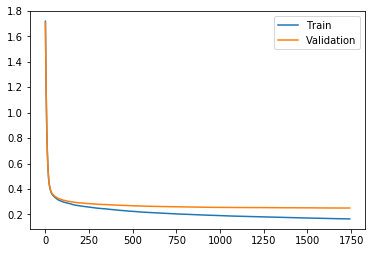

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.legend();

## Model Interpretation

### Feature Importances

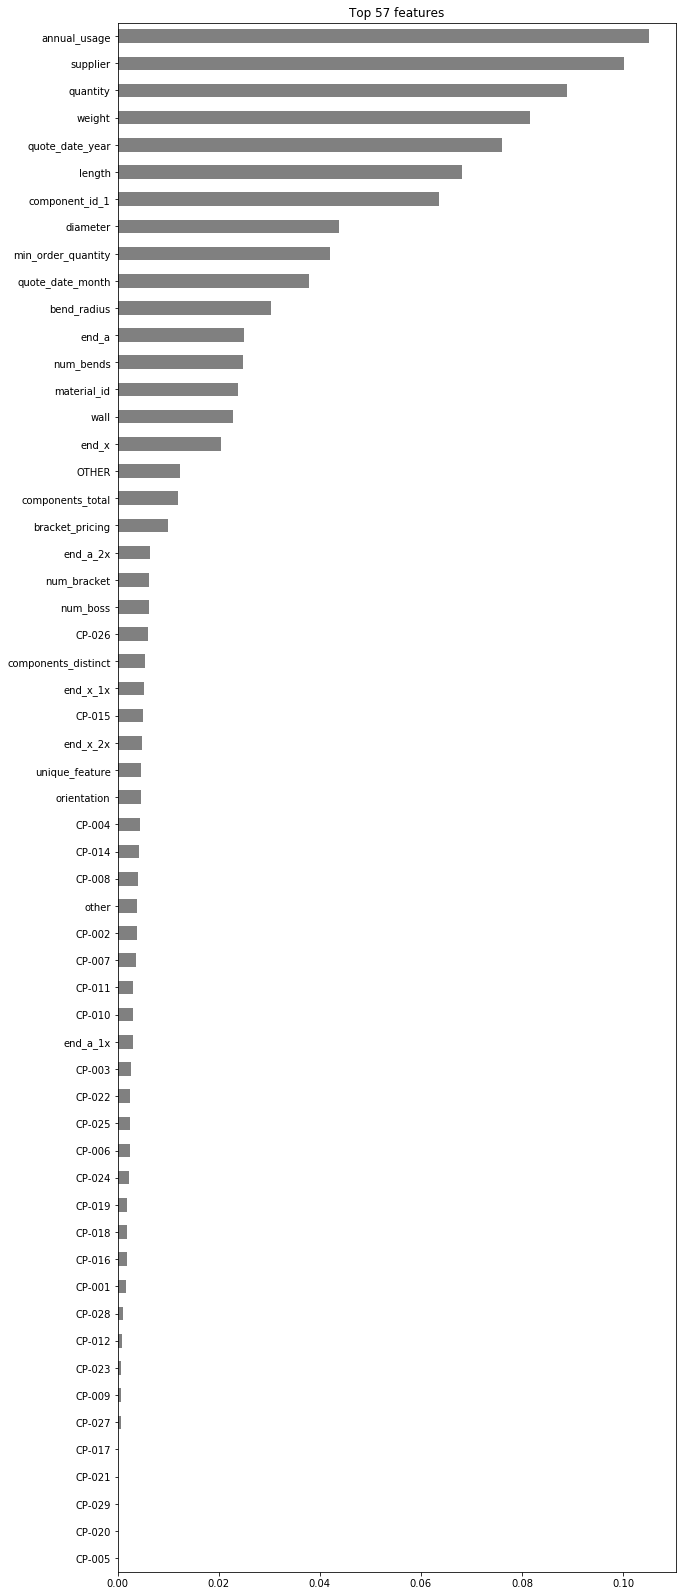

In [27]:

importances = pd.Series(model.feature_importances_, X_train_encoded.columns)

# Plot 
n = len(X_train_encoded.columns)
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

### Permutation Importance

In [31]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_val_encoded, y_val_log)
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.7374 ± 0.0024,quantity
0.2602 ± 0.0033,min_order_quantity
0.0651 ± 0.0020,annual_usage
0.0603 ± 0.0053,supplier
0.0444 ± 0.0009,diameter
0.0410 ± 0.0019,quote_date_year
0.0340 ± 0.0002,weight
0.0198 ± 0.0031,length
0.0117 ± 0.0011,wall
0.0086 ± 0.0010,component_id_1


### Partial Dependence Plots

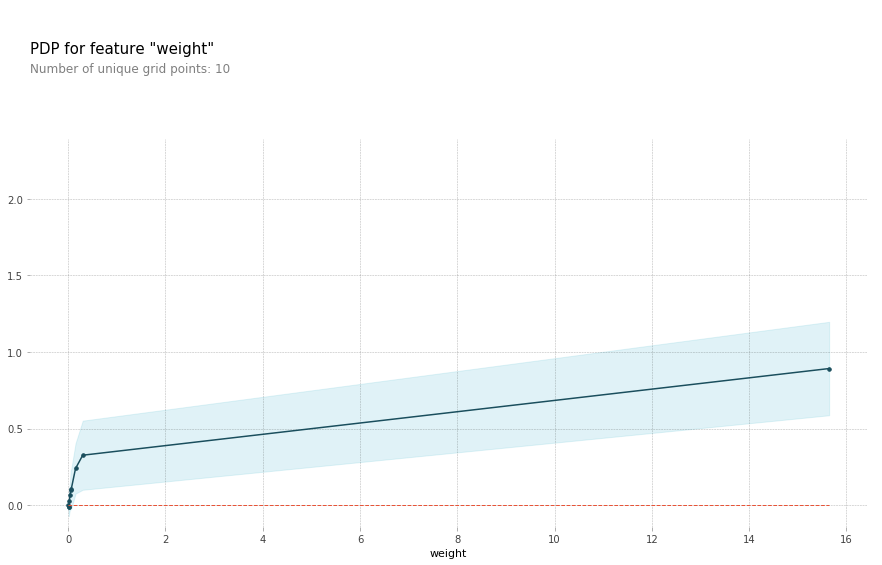

In [33]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'weight'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

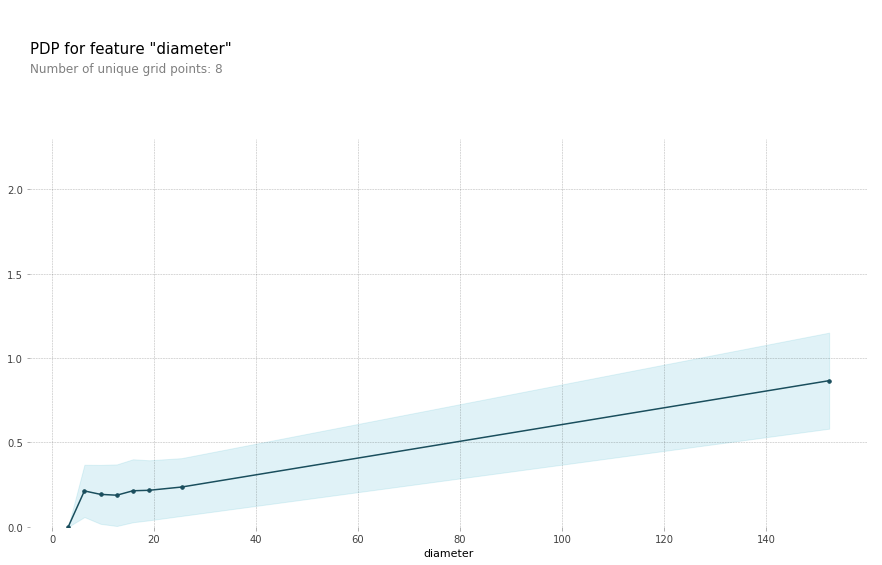

In [34]:

feature = 'diameter'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

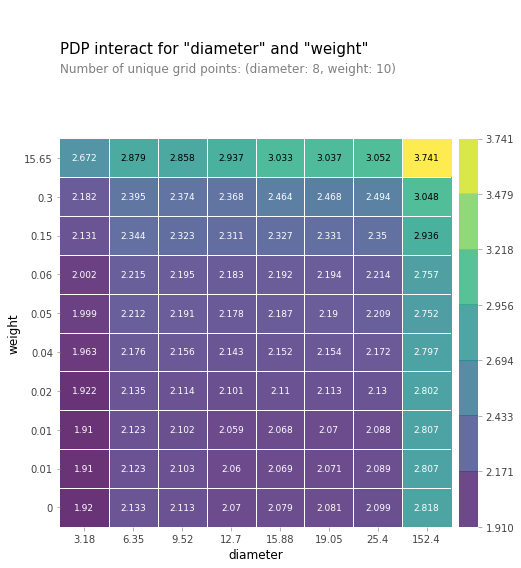

In [35]:
# 2 features
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['diameter', 'weight']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

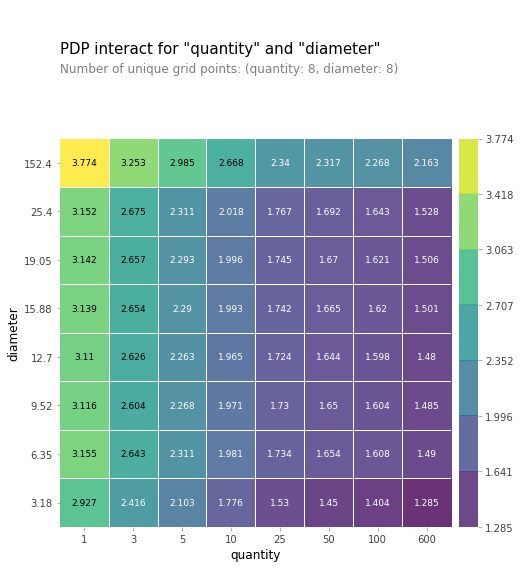

In [36]:
# 2 features
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['quantity', 'diameter']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);